# Polkadot (DOT) Time Series Analysis and Prediction Using ARIMA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12

In [3]:
data = pd.read_csv('dot-usd-max.csv', sep=',')

In [4]:
data['snapped_at'] = pd.to_datetime(data['snapped_at'])

In [5]:
data.set_index(data['snapped_at'], inplace=True)

In [6]:
p_data = data[['price']]

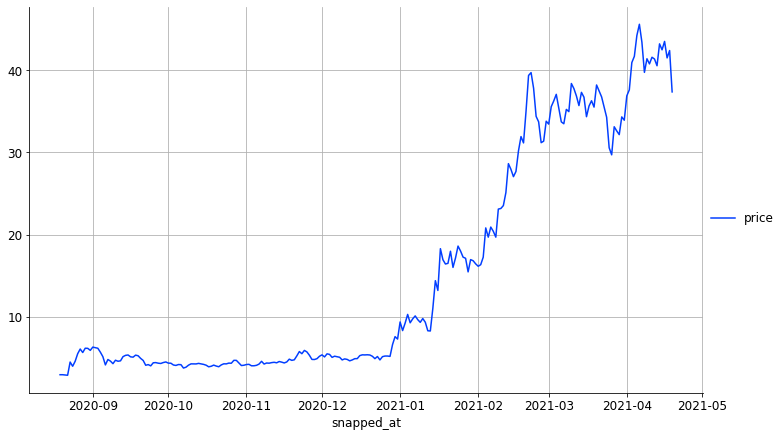

In [7]:
# Plot Graph
sns.set_palette('bright')
sns.relplot(data=p_data, kind='line',height=6, aspect=10/6)
plt.show()

**Observations**

Clearly from the plot above the figure graph is not stationary. For our analysis and prediction the graph has to be transformed to be stationary.

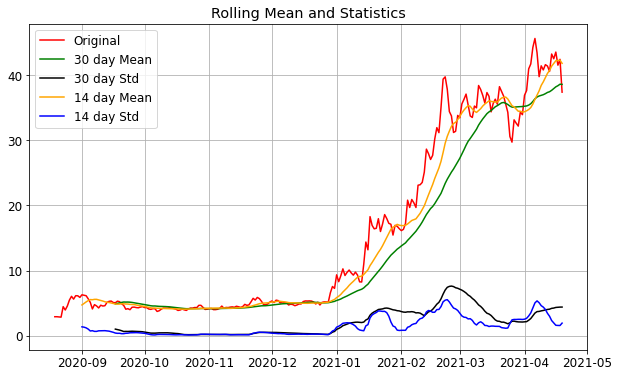

In [8]:
# Rolling Statistics with a window of 14 days and 30 days
rolmean = p_data.rolling(window=30).mean()
rolstd = p_data.rolling(window=30).std()

rolmean_14 = p_data.rolling(window=14).mean()
rolstd_14 = p_data.rolling(window=14).std()

#plotting the Rolling Statisitics
plt.figure(figsize=(10,6))
sns.set_palette('bright')
orig = plt.plot(p_data, color= 'red', label='Original')
mean = plt.plot(rolmean, color='green', label='30 day Mean')
std = plt.plot(rolstd, color='black', label='30 day Std')

mean_14 = plt.plot(rolmean_14, color='orange', label='14 day Mean')
std_14 = plt.plot(rolstd_14, color='blue', label='14 day Std')
plt.title('Rolling Mean and Statistics')
plt.legend(loc='best')
plt.show()

**Observations**

For purposes of longterm forecast(about 7 months) we will use the monthly moving average

In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(X):
    rolmean = X.rolling(window=30).mean()
    rolstd = X.rolling(window=30).std()

    #Plot the Rolling Stats
    plt.figure(figsize=(10,6))
    sns.set_palette('bright')

    orig = plt.plot(X, color= 'red', label='Original')
    mean = plt.plot(rolmean, color='green', label='30 day Mean')
    std = plt.plot(rolstd, color='black', label='30 day Std')
    plt.legend(loc='best')
    plt.show()

    adtest = adfuller(X, autolag='AIC')
    adout = pd.Series(adtest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'No. of Observations'])
    for key, value in adtest[4].items():
        adout['Critical Value (%s)'%key] = value
    
    print(adout)

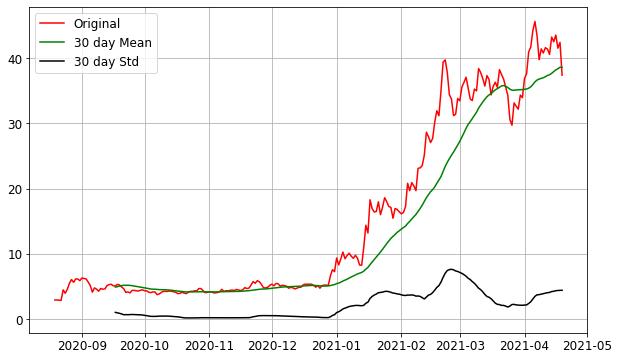

Test Statistic           -0.057626
p-value                   0.953499
#Lags Used                0.000000
No. of Observations     243.000000
Critical Value (1%)      -3.457551
Critical Value (5%)      -2.873509
Critical Value (10%)     -2.573148
dtype: float64


In [10]:
test_stationarity(p_data)

**Observation**

By means of the p-value we support the null hypothesis(the graph is not stationary - no constant variance and mean)


#### Converting to a Stationary Timeseries


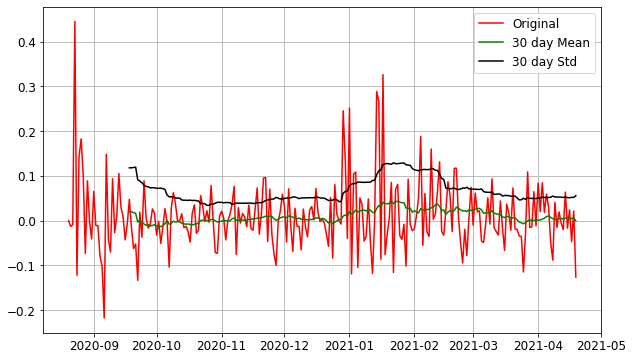

Test Statistic         -7.509572e+00
p-value                 4.049088e-11
#Lags Used              2.000000e+00
No. of Observations     2.400000e+02
Critical Value (1%)    -3.457894e+00
Critical Value (5%)    -2.873659e+00
Critical Value (10%)   -2.573229e+00
dtype: float64


In [11]:
# Combining both Log and Differencing
p_data_log = np.log(p_data)

p_data_log_shift = p_data_log - p_data_log.shift()
p_data_log_shift.dropna(inplace=True)
test_stationarity(p_data_log_shift)

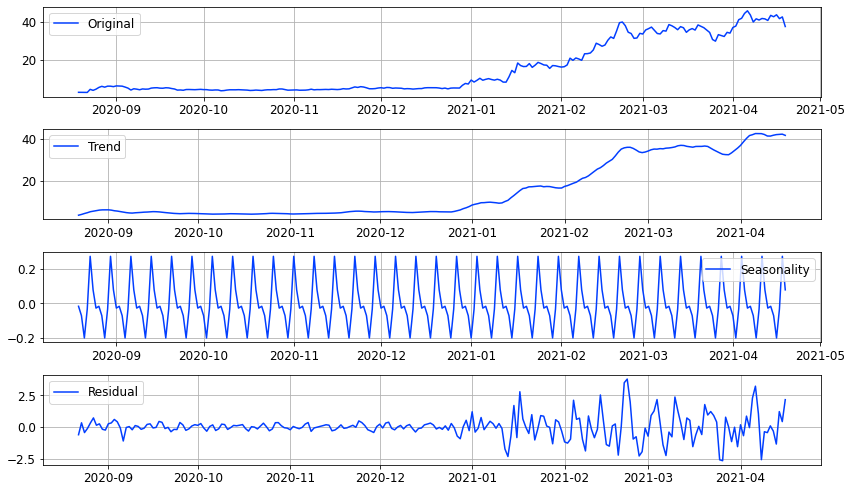

In [12]:
#Using Decompose

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(p_data)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,7))
sns.set_palette('bright')
plt.subplot(411)
plt.plot(p_data, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

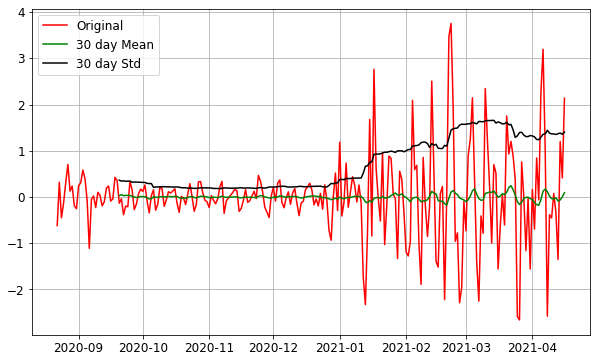

Test Statistic         -7.044002e+00
p-value                 5.749220e-10
#Lags Used              1.400000e+01
No. of Observations     2.230000e+02
Critical Value (1%)    -3.460019e+00
Critical Value (5%)    -2.874590e+00
Critical Value (10%)   -2.573725e+00
dtype: float64


In [13]:
test_stationarity(residual.dropna())

**Observations**

Separately,  log and differencing works to resolve the non-stationary series to have the lowest p-value. Therefore this notebook will use log and differencing.

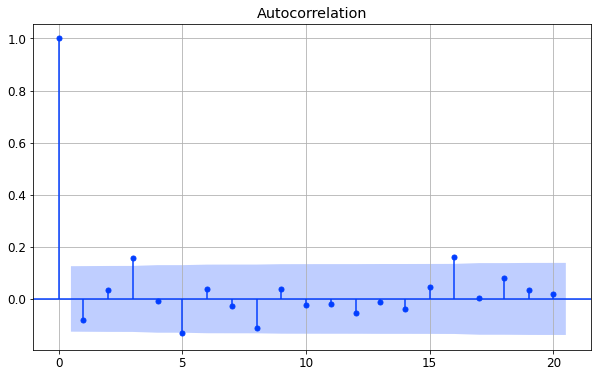

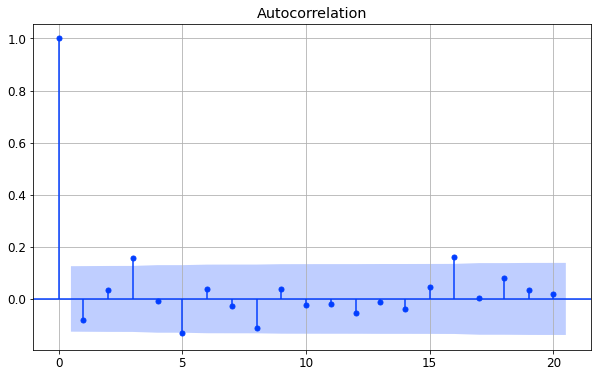

In [14]:
# Select the best ARIMA order using auto and partial correlation plots

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(p_data_log_shift.dropna(), lags=20)

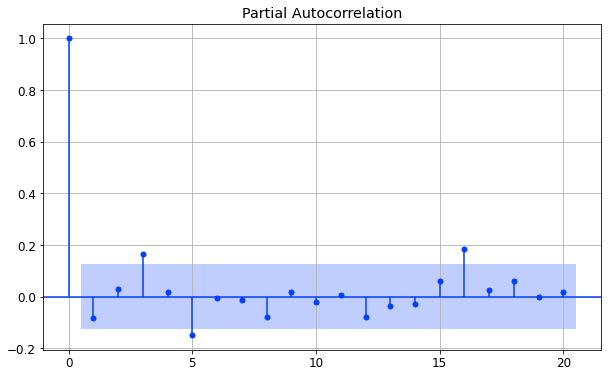

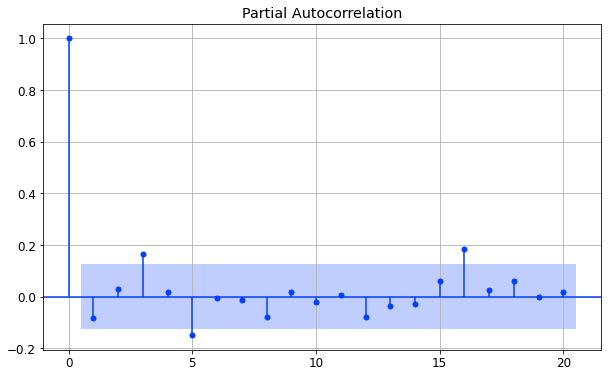

In [15]:
plot_pacf(p_data_log_shift.dropna(), lags=20, method='ols')

**Observations**

From the ACF and ACF our ARIMA model will have p=1 and q=1 with d=1

/home/nyamwamu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/nyamwamu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so infe

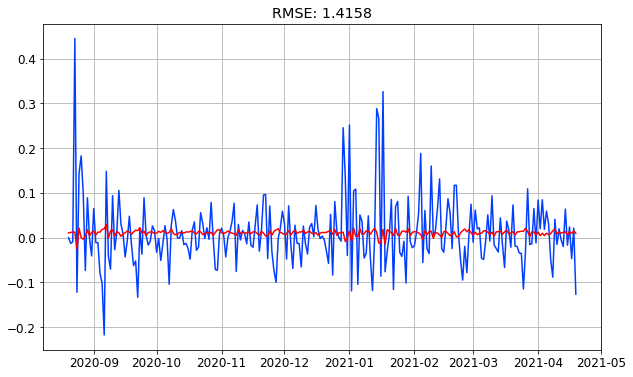

In [16]:
from statsmodels.tsa.arima_model import ARIMA

#AR
model = ARIMA(p_data_log, order=(1,1,0))
results_AR = model.fit(disp=-1)
sns.set_palette('bright')
plt.plot(p_data_log_shift)
plt.plot(results_AR.fittedvalues, color='red', label='Fitted Values')
plt.title('RMSE: %.4f'%sum((results_AR.fittedvalues - p_data_log_shift['price'])**2))
plt.show()

/home/nyamwamu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nyamwamu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


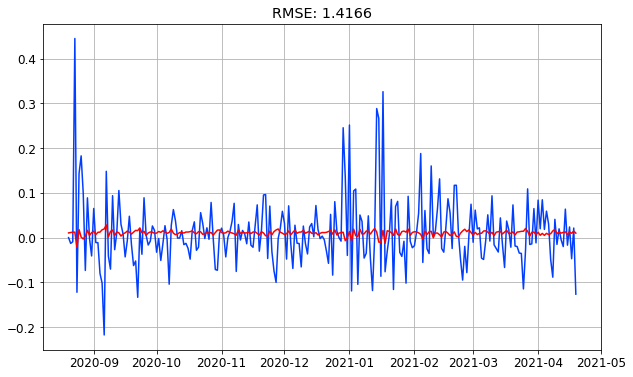

In [17]:
#AR
model = ARIMA(p_data_log, order=(0,1,1))
results_MA = model.fit(disp=-1)
sns.set_palette('bright')
plt.plot(p_data_log_shift)
plt.plot(results_MA.fittedvalues, color='red', label='Fitted Values')
plt.title('RMSE: %.4f'%sum((results_MA.fittedvalues - p_data_log_shift['price'])**2))
plt.show()

/home/nyamwamu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nyamwamu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nyamwamu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they ar

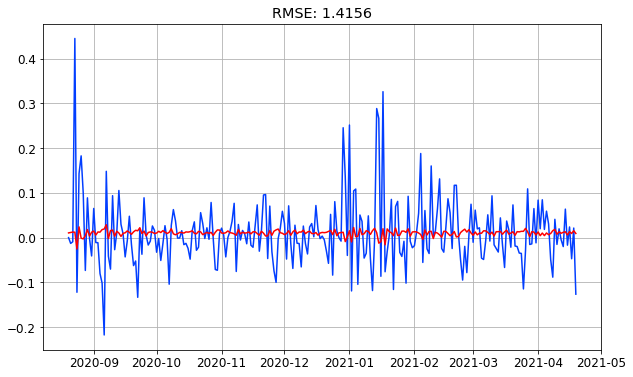

In [18]:
#ARIMA
model = ARIMA(p_data_log, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
sns.set_palette('bright')
plt.plot(p_data_log_shift)
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values')
plt.title('RMSE: %.4f'%sum((results_ARIMA.fittedvalues - p_data_log_shift['price'])**2))
plt.show()

In [19]:
fitted_values = pd.Series(results_ARIMA.fittedvalues, copy=True)
fitted_values

snapped_at
2020-08-20 00:00:00+00:00    0.010511
2020-08-21 00:00:00+00:00    0.011382
2020-08-22 00:00:00+00:00    0.012387
2020-08-23 00:00:00+00:00    0.012015
2020-08-24 00:00:00+00:00   -0.025394
                               ...   
2021-04-15 00:00:00+00:00    0.005965
2021-04-16 00:00:00+00:00    0.013085
2021-04-17 00:00:00+00:00    0.009240
2021-04-18 00:00:00+00:00    0.015357
2021-04-19 00:00:00+00:00    0.009282
Length: 243, dtype: float64

In [20]:
fitted_values_cumsum = fitted_values.cumsum()
fitted_values_cumsum

snapped_at
2020-08-20 00:00:00+00:00    0.010511
2020-08-21 00:00:00+00:00    0.021894
2020-08-22 00:00:00+00:00    0.034280
2020-08-23 00:00:00+00:00    0.046295
2020-08-24 00:00:00+00:00    0.020901
                               ...   
2021-04-15 00:00:00+00:00    2.497428
2021-04-16 00:00:00+00:00    2.510513
2021-04-17 00:00:00+00:00    2.519753
2021-04-18 00:00:00+00:00    2.535110
2021-04-19 00:00:00+00:00    2.544392
Length: 243, dtype: float64

In [21]:
preds_ARIMA_log = pd.Series(p_data_log['price'].iloc[0], index=p_data_log.index)
preds_ARIMA_log = preds_ARIMA_log.add(fitted_values_cumsum, fill_value=0)
preds_ARIMA_log

snapped_at
2020-08-19 00:00:00+00:00    1.077275
2020-08-20 00:00:00+00:00    1.087786
2020-08-21 00:00:00+00:00    1.099168
2020-08-22 00:00:00+00:00    1.111555
2020-08-23 00:00:00+00:00    1.123570
                               ...   
2021-04-15 00:00:00+00:00    3.574703
2021-04-16 00:00:00+00:00    3.587787
2021-04-17 00:00:00+00:00    3.597027
2021-04-18 00:00:00+00:00    3.612385
2021-04-19 00:00:00+00:00    3.621666
Length: 244, dtype: float64

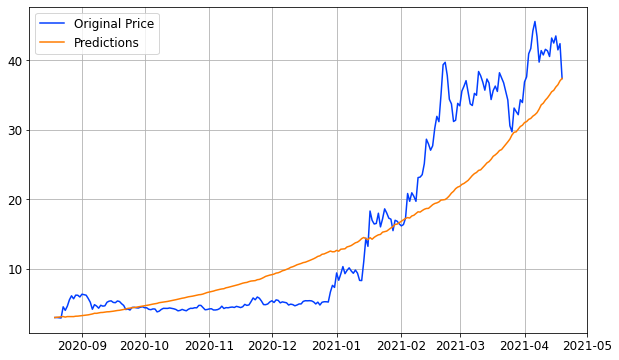

In [22]:
ARIMA_preds = np.exp(preds_ARIMA_log)
sns.set_palette('bright')
plt.plot(p_data['price'], label='Original Price')
plt.plot(ARIMA_preds, label='Predictions')
plt.legend(loc='best')
plt.show()

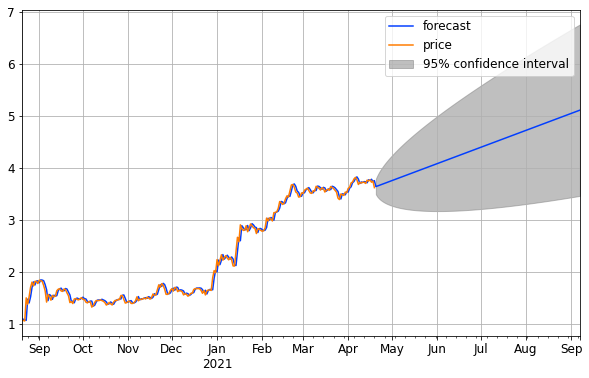

In [29]:
# Predicting for 5 months
results_ARIMA.plot_predict(1, 384)
X = results_ARIMA.forecast(steps=140)[0]

In [31]:
#creating the timeseries of predicted close values

dates = pd.date_range(start=p_data.index[0], periods=384)
pred = pd.concat([p_data['price'], pd.Series(np.exp(X))], axis=0)
pred.index = dates
pred.columns = ['time', 'price']
DOT = pd.DataFrame(pred)

In [32]:
DOT.reset_index(inplace=True)
DOT.columns = ['time', 'price']
DOT.set_index(['time'], inplace=True)

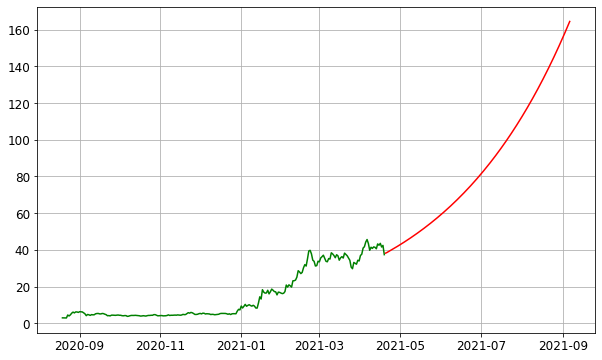

In [33]:
sns.set_palette('bright')
plt.plot(DOT.iloc[0:244], color='green')
plt.plot(DOT.iloc[244:], color='red')
#sns.relplot(data = DOT, kind='line', height=6, aspect=10/6)
plt.show()